<a href="https://colab.research.google.com/github/kkgh2024/Disaster_Tweet_Classification/blob/master/Tweet_mini_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Language Processing with Disaster Tweets

## Challenge: Disaster Tweet Classification

In this competition, the challenge is to build a machine learning model that can accurately predict whether a Tweet is about a real disaster or not.

## Dataset Description

**File Descriptions:**



*   train.csv: Contains the training data
*   test.csv: Contains the test data

*   sample_submission.csv: A sample file showing the correct submission format

**Column Descriptions:**


*   id: Unique identifier for each tweet

*   text: The text of the tweet
*   location: The location the tweet was sent from

*  target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

The dataset of 10,000 Tweets  have been manually classified.









In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Jun 18 01:57:40 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0              27W /  70W |   8309MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# Unzip and load the dataset onto your current directory

import zipfile

zip = zipfile.ZipFile('/content/drive/MyDrive/Tweet_Analysis/nlp-getting-started.zip')

zip.extractall("/content/drive/MyDrive/Tweet_Analysis/")

In [ ]:
!pip install tf-keras==2.15.0

In [ ]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = 'True'

In [ ]:
#!pip uninstall tensorflow

In [ ]:
#!pip install tensorflow==2.15.0

In [ ]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = 'True'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Let's begin by setting up our environment and importing the necessary libraries.

In [ ]:
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
print(tf.__version__)
try:
  import ktrain
except:
  !pip install ktrain
  os.kill(os.getpid(), 9)
from ktrain import text
from ktrain.text import texts_from_df
import time
import pandas as pd
from keras.preprocessing.text import Tokenizer
import nltk
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob
import numpy as np
import matplotlib.pyplot as plt
import nltk
import string

2.15.0


## Load the Disaster Tweets

Read data:

In [ ]:
df_train = pd.read_csv("/content/drive/MyDrive/Tweet_Analysis/train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/Tweet_Analysis/test.csv")

## Data Exploratory Analysis

In [ ]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1



### DataFrame Summary:

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


The DataFrame comprises 7,503 entries with 6 columns, including unique identifiers, text data, and related metadata. There are missing values in the 'keyword' and 'location' columns, with the 'location' column having the highest number of missing entries (2,482). The data is mostly complete, with each row containing a non-null text entry and target variable.

### Duplicate Data

#### Check if there is duplicate data (where the same text is repeated).

In [ ]:
# Check for duplicate rows based on 'text' column
duplicate_rows =df_train[df_train.duplicated('text', keep=False)]

if len(duplicate_rows) > 0:
    print("Duplicate rows found based on 'text' column:")
    print(len(duplicate_rows))
else:
    print("No duplicate rows found based on 'text' column.")

Duplicate rows found based on 'text' column:
179


### Remove duplicate rows

In [ ]:
# Remove duplicate rows based on 'text' column
df_train = df_train.drop_duplicates(subset=['text'])



##### Check again that duplicate rows were removed

In [ ]:
# Check for duplicate rows based on 'text' column
duplicate_rows =df_train[df_train.duplicated('text', keep=False)]

if len(duplicate_rows) > 0:
    print("Duplicate rows found based on 'text' column:")
    print(len(duplicate_rows))
else:
    print("No duplicate rows found based on 'text' column.")

No duplicate rows found based on 'text' column.


### Missing Values

In [ ]:
# Check for missing values
missing_values = df_train.isnull().sum()

# Print the count of missing values for each column
print(missing_values)

id             0
keyword       56
location    2482
text           0
target         0
dtype: int64


Since our analysis only requires the text and target columns, we don't need to worry about the other inputs.

## Natural Language Processing for Our Tweet Data

In [ ]:
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## The number of unique words in our dataset

In [ ]:
TWEET_TOKENIZER = nltk.TweetTokenizer().tokenize
WORD_TOKENIZER = nltk.tokenize.word_tokenize
STEMMER = nltk.PorterStemmer()
LEMMATIZER = nltk.WordNetLemmatizer()
STOPWORDS_SET = set(nltk.corpus.stopwords.words("english"))
POS_TAGS = ['NNP', 'NN', 'NNS', 'NNPS', 'JJ', 'JJR', 'JJS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']

def tokenize(text, lowercase=True, tweet=False):
    if lowercase:
        text = text.lower()
    return TWEET_TOKENIZER(text) if tweet else WORD_TOKENIZER(text)

def removeLinks(tokens):
    return [t for t in tokens if not t.startswith("http://") and not t.startswith("https://")]

def stem(tokens):
    return [STEMMER.stem(token) for token in tokens]

def lemmatize(tokens):
    return [LEMMATIZER.lemmatize(*token) if isinstance(token, tuple) else LEMMATIZER.lemmatize(token) for token in tokens]

def removeStopWords(tokens, stopwords=None):
    stopwords = stopwords or STOPWORDS_SET
    return [token for token in tokens if token not in stopwords]

def removePunctuation(tokens, strip_mentions=False, strip_hashtags=False, strict=False):
    tokens = [t for t in tokens if t not in string.punctuation]
    if strip_mentions:
        tokens = [t.lstrip('@') for t in tokens]
    if strip_hashtags:
        tokens = [t.lstrip('#') for t in tokens]
    if strict:
        tokens = [t.translate(str.maketrans('', '', string.punctuation)).strip() for t in tokens if t]
    return tokens

def removeSingleWords(tokens):
    return [word for word in tokens if len(word) > 1]

def filterPartsOfSpeech(tokens, tagger=nltk.tag.PerceptronTagger().tag, parts_of_speech=None):
    tags = tagger(tokens)
    return list(set(tag[0] for tag in tags if parts_of_speech is None or tag[1] in parts_of_speech))



This code defines several functions for preprocessing text data using the Natural Language Toolkit (nltk). It sets up tokenizers for tweets and regular text, a stemmer, a lemmatizer, and a set of English stopwords. The tokenize function converts text to lowercase and tokenizes it, using a tweet-specific tokenizer if specified. The removeLinks function filters out tokens that start with "http://" or "https://". The stem and lemmatize functions apply stemming and lemmatization to the tokens, respectively. The removeStopWords function removes common stopwords from the tokens. The removePunctuation function removes punctuation from tokens, with options to strip mentions and hashtags, and a strict mode to remove all punctuation. The removeSingleWords function removes tokens that are single characters. The filterPartsOfSpeech function filters tokens based on specified parts of speech, using a perceptron tagger.

In [ ]:
word_counts = {}
for tweet_text in df_train['text']:

        tokens = tokenize(tweet_text, tweet=True)
        tokens = filterPartsOfSpeech(tokens, parts_of_speech=POS_TAGS)
        tokens = removeLinks(tokens)
        tokens = removeStopWords(tokens)
        tokens = removePunctuation(tokens)
        tokens = lemmatize(tokens)
        tokens = removeSingleWords(tokens)
        for word in tokens:
            if word not in word_counts:
                word_counts[word] = 0
            word_counts[word] += 1

In [ ]:
len(word_counts)

15770

We have 15770 unique words in our data

### How many unique words in each row or for each tweet?

In [ ]:
def get_word_count(text):
    tokens = tokenize(text, tweet=True)
    tokens = filterPartsOfSpeech(tokens, parts_of_speech=POS_TAGS)
    tokens = removeLinks(tokens)
    tokens = removeStopWords(tokens)
    tokens = removePunctuation(tokens, strip_mentions=True, strip_hashtags=True)
    tokens = lemmatize(tokens)
    tokens = removeSingleWords(tokens)
    return len(tokens)

In [ ]:
# Add 'word_count' column to df_train
df_train['word_count'] = df_train['text'].apply(get_word_count)

# Print df_train with new 'word_count' column
#df_train.head()

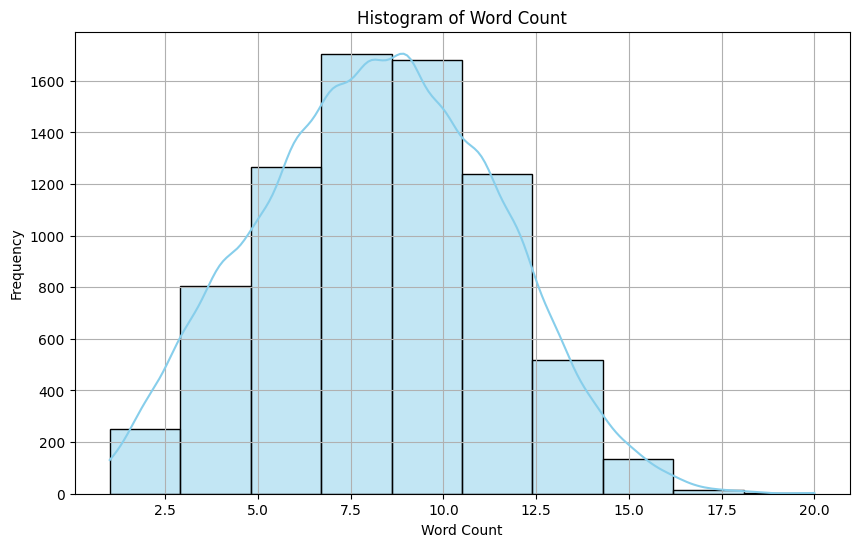

In [ ]:
# Create histogram using Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(data=df_train, x='word_count', bins=10, kde=True, color='skyblue')
plt.title('Histogram of Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Summary of word_count histogram:
* The majority of text entries in the dataset have word counts between 5 and 12 words, with the peak around 8-9 words.
* There are very few text entries with extremely low or high word counts.
* The distribution of word counts is roughly symmetrical, suggesting a consistent length for most entries in the dataset.

### Clean Text
Clean the text in our data to use it in our deep learning model

In [ ]:
def clean_tweet(text):
    tokens = tokenize(text, tweet=True)
    tokens = filterPartsOfSpeech(tokens, parts_of_speech=POS_TAGS)
    tokens = removeLinks(tokens)
    tokens = removeStopWords(tokens)
    tokens = removePunctuation(tokens, strip_mentions=True, strip_hashtags=True)
    tokens = lemmatize(tokens)
    tokens = removeSingleWords(tokens)
    return ' '.join(tokens)

In [ ]:
# Clean the 'text' column in the DataFrame using filterDataset function
df_train['cleaned_text'] = df_train['text'].apply(lambda x: clean_tweet(x))
df_train.head()

,id,keyword,location,text,target,cleaned_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,allah forgive earthquake reason deed
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,ronge sask la fire canada forest
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,asked shelter place officer order expected res...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people order receive wildfire california evacu...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,photo ruby got sent pours school wildfire alas...


## Sentiment Analysis of Our Tweets

### Negative Sentiment

In [ ]:
def get_negative_texts(texts):
    negative_texts = []
    for text in texts:
        analysis = TextBlob(text)
        if analysis.sentiment.polarity < 0.0:
            negative_texts.append(text)
    return negative_texts

In [ ]:
texts = df_train['cleaned_text'].tolist()

In [ ]:
negative_tweets = get_negative_texts(texts)

In [ ]:
len(negative_tweets)

1507

In [ ]:
negative_tweets [:5]

['expected officer resident place shelter asked evacuation order notified',
 'update hwy rockyfire direction fire county cafire wildfire due closed lake california',
 'flood cause heavy rain area flooding disaster spring flash manitou colorado street',
 "tornado coming area afraid i'm",
 'ridiculous']

In [ ]:
# length of negavie tweets
len(negative_tweets)

1507

**Insights into negative sentiments**

The insights provided from negative sentiment show a troubled landscape affected by natural disasters like wildfires, floods, and fears of tornadoes leading to evacuations. There are frequent reports of accidents involving vehicles, helicopters, and airplanes, highlighting tragic consequences and disruptions in communities. Incidents of arson add to the distress, with intentional fires occurring at churches and homes. Emotional responses ranging from fear to frustration emphasize how deeply these events affect people personally. Cultural references and social commentary, along with mentions of media and entertainment, reveal a broader societal backdrop of unrest and turmoil. Together, these snippets portray a society dealing with crises, accidents, crime, and social challenges, presenting a complex view of contemporary issues and reactions.

### Positive Sentiment

In [ ]:
def get_positive_texts(texts):

    pass # TODO: Implement this function
    positive_texts = []
    for text in texts:
        analysis = TextBlob(text)
        if analysis.sentiment.polarity >= 0.0:
            positive_texts.append(text)
    return positive_texts

In [ ]:
positive_tweets = get_positive_texts(texts)

In [ ]:
# length of positive tweets
len(positive_tweets)

5996

**Insights into positive sentiments**

The positive sentiments offer insights into sports enthusiasm, community events, cultural activities, and personal interests, highlighting a broad spectrum of topics and engagements.

### Check if the target variable is balanced.

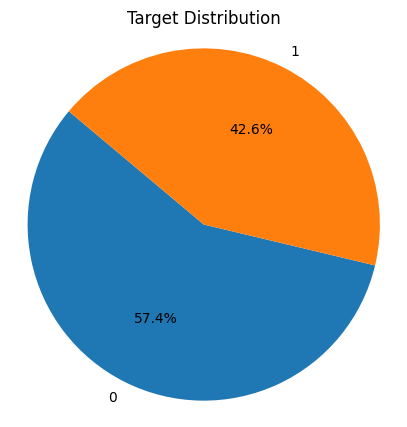

In [ ]:
target_counts = df_train['target'].value_counts()

# Plot a pie chart
plt.figure(figsize=(5, 5))
plt.pie(target_counts, labels=target_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Target Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()#positive_tweets[1:5]

The dataset contains more non-disaster tweets than disaster tweets. The distribution is fairly balanced but slightly skewed towards non-disaster tweets.

In [ ]:
# Update target values directly
df_train.loc[df_train['target'] == 1, 'target'] = 'DISASTER'
df_train.loc[df_train['target'] == 0, 'target'] = 'NOT DISASTER'

# Display the updated DataFrame
df_train.head()

,id,keyword,location,text,target,cleaned_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,DISASTER,allah forgive earthquake reason deed
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,DISASTER,ronge sask la fire canada forest
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,DISASTER,asked shelter place officer order expected res...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",DISASTER,people order receive wildfire california evacu...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,DISASTER,photo ruby got sent pours school wildfire alas...


This code is used to transform numeric or categorical target values into more understandable labels ('DISASTER' and 'NOT DISASTER'). This transformation is beneficial for enhancing the interpretability of the target variable in machine learning.

**Next, we prepare the data for the BERT model, setting a maximum token length and splitting the data into training and validation sets.**

In [ ]:
target_names = ['NOT DISASTER','DISASTER']

In [ ]:
#tf.keras.backend.clear_session()
t = text.Transformer('distilbert-base-uncased', maxlen=512, class_names=target_names)

This code sets up a transformer model for handling text tasks, makes sure there's no leftover TensorFlow data (if you clear the session), and sets how the model reads input and predicts different classes for tasks like classification.

##### Split the data into training and validation datasets.

In [ ]:
train, val, preprocess = texts_from_df(df_train, 'cleaned_text', label_columns=['target'], val_df=None, max_features=20000, maxlen=512, val_pct=0.1, ngram_range=1, preprocess_mode='distilbert', verbose=1)

['DISASTER', 'NOT DISASTER']
      DISASTER  NOT DISASTER
4524       1.0           0.0
676        0.0           1.0
6176       0.0           1.0
6463       1.0           0.0
489        1.0           0.0
['DISASTER', 'NOT DISASTER']
      DISASTER  NOT DISASTER
2357       0.0           1.0
1202       1.0           0.0
2097       0.0           1.0
4106       1.0           0.0
6079       0.0           1.0
preprocessing train...
language: en
train sequence lengths:
	mean : 8
	95percentile : 13
	99percentile : 15


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 8
	95percentile : 13
	99percentile : 15


This code prepares textual data from df_train to train a machine learning model, ensuring it's correctly structured and formatted for compatibility with transformer-based models such as DistilBERT.

**Set up the DistilBERT transformer model(Model Architecture)**

In [ ]:
model = preprocess.get_classifier()
learner = ktrain.get_learner(model, train_data=train, val_data=val, batch_size=16)

This code sets up a way to train a model that understands text, probably using a method called DistilBERT. First, it gets the model ready for training with model = preprocess.get_classifier(). Then, learner = ktrain.get_learner(...) starts the training process. Using the ktrain library makes it easier to train these types of deep learning models. It splits the data into small batches of 16 samples each (batch_size=16) to save memory and train faster. This setup makes it possible to train and test the model effectively on specific sets of data (training and validation), which is great for jobs like sorting text or understanding feelings.

**Tuning hyperparameters**: Fine-tuning the learning rate to minimize the loss.function

In [ ]:
learner.lr_find(max_epochs=30)

simulating training for different learning rates... this may take a few moments...
Epoch 1/30
422/422 [==============================] - 396s 890ms/step - loss: 0.6786 - accuracy: 0.5788
Epoch 2/30
422/422 [==============================] - 375s 887ms/step - loss: 0.6641 - accuracy: 0.5940
Epoch 3/30
422/422 [==============================] - 374s 887ms/step - loss: 0.5988 - accuracy: 0.7325
Epoch 4/30
422/422 [==============================] - 375s 888ms/step - loss: 0.4830 - accuracy: 0.7996
Epoch 5/30
422/422 [==============================] - 374s 887ms/step - loss: 0.4329 - accuracy: 0.8150
Epoch 6/30
422/422 [==============================] - 375s 888ms/step - loss: 0.4017 - accuracy: 0.8319
Epoch 7/30
422/422 [==============================] - 374s 887ms/step - loss: 0.3681 - accuracy: 0.8532
Epoch 8/30
422/422 [==============================] - 375s 888ms/step - loss: 0.3344 - accuracy: 0.8714
Epoch 9/30
422/422 [==============================] - 375s 888ms/step - loss: 0.2993 

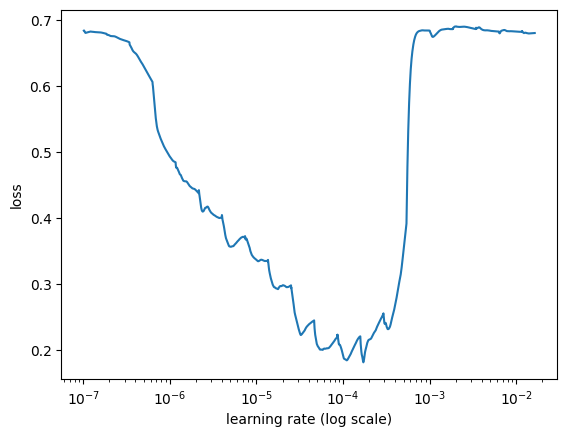

In [ ]:
learner.lr_plot()

The optimal value that minimizes the loss function is $10^4$. We will now train the model using the autofit method, which includes early stopping to prevent overfitting.


In [ ]:
history=learner.autofit(10**(-3.9),checkpoint_folder='checkpoint',epochs=12, early_stopping=True)



begin training using triangular learning rate policy with max lr of 0.00012589254117941674...
Epoch 1/12
422/422 [==============================] - 404s 910ms/step - loss: 0.4715 - accuracy: 0.7804 - val_loss: 0.4255 - val_accuracy: 0.8083
Epoch 2/12
422/422 [==============================] - 377s 894ms/step - loss: 0.3451 - accuracy: 0.8597 - val_loss: 0.4466 - val_accuracy: 0.8016
Epoch 2: early stopping
Weights from best epoch have been loaded into model.


 This code  efficiently trains a machine learning model using predefined hyperparameters and automated training techniques, ensuring effective learning and optimal performance while handling checkpoints and early stopping to enhance efficiency and effectiveness.

 **The model's performance on the validation set.**

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc=preprocess)

In [ ]:
validation = learner.validate(val_data=val, print_report=True)

24/24 [==============================] - 1s 46ms/step
              precision    recall  f1-score   support

           0       0.86      0.67      0.76       330
           1       0.78      0.91      0.84       421

    accuracy                           0.81       751
   macro avg       0.82      0.79      0.80       751
weighted avg       0.82      0.81      0.80       751



## Why  this model:?

The model is set up well for training with DistilBERT, a powerful tool for understanding language. It adjusts settings like the learning rate automatically (10**(-3.9)), saves progress with checkpoints, and stops training early to save time. The ktrain library makes training easier by providing useful tools and making complex tasks simpler. It processes data in  batches of 30 to use memory efficiently. Checking how well it's doing during training and stopping early if needed ensures it learns well without getting too focused on specific data. Tuning the settings carefully helps make sure it works as effectively as possible. Overall, these choices make the model ready to handle tasks like classification, sorting text or understanding feelings, using advanced methods to understand how words work together.

##  submission

In [ ]:
# Convert the DataFrame to a list of texts or inputs
test_texts = df_test['text'].tolist()

In [ ]:
# Get predictions
predictions = predictor.predict(test_texts)  # or predictor.predict_proba(test_texts) for probabilities

# If you want to add the predictions back to the DataFrame
df_test['target'] = predictions

In [ ]:
df_test.head()

,id,keyword,location,text,target
0,0,NaN,NaN,Just happened a terrible car crash,DISASTER
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",DISASTER
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",DISASTER
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,DISASTER
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,DISASTER


In [ ]:
# Map target labels to numerical values
df_test['target'] = df_test['target'].map({'DISASTER': 1, 'NOT DISASTER': 0})
sample_submission = pd.read_csv("/content/drive/MyDrive/Tweet_Analysis/sample_submission.csv")
sample_submission["target"]  = df_test["target"]
sample_submission.to_csv("/content/drive/MyDrive/Tweet_Analysis/submission.csv", index=False)

In [ ]:
# Count occurrences of 1 and 0 in the target column
target_counts = df_test['target'].value_counts()

# Display the counts
print(target_counts)

target
NOT DISASTER    2009
DISASTER        1254
Name: count, dtype: int64


In [ ]:
df_test['target'] = df_test['target'].map({'DISASTER': 1, 'NOT DISASTER': 0})
# Map target labels to numerical values


In [ ]:
# Map target labels to numerical values
df_test['target'] = df_test['target'].map({'DISASTER': 1, 'NOT DISASTER': 0})

In [ ]:
# Count occurrences of 1 and 0 in the target column
target_counts = df_test['target'].value_counts()

# Display the counts
print(target_counts)

target
0    2009
1    1254
Name: count, dtype: int64


In [ ]:
df_test.head()

,id,keyword,location,text,target
0,0,NaN,NaN,Just happened a terrible car crash,1
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",1
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",1
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,1
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,1


In [ ]:
sample_submission = pd.read_csv("/content/drive/MyDrive/Tweet_Analysis/sample_submission.csv")
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [ ]:
sample_submission["target"]  = df_test["target"]

In [ ]:
sample_submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [ ]:
sample_submission.to_csv("/content/drive/MyDrive/Tweet_Analysis/submission.csv", index=False)

# Summary

The model performs well with an overall accuracy of 81%. It is better at identifying disaster tweets (class 1) than non-disaster tweets (class 0), as indicated by higher recall and F1-score for class 1. The precision, recall, and F1-score are reasonably balanced, indicating a reliable model.